In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
dataset_dir = os.path.join(os.getcwd(), 'stack_overflow_16k')

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('stack_overflow_16k/train',batch_size = batch_size, validation_split = 0.2, subset = 'training', seed = seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        'stack_overflow_16k/train',
        batch_size = batch_size,
        validation_split = 0.2,
        subset='validation',
        seed = seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]'%re.escape(string.punctuation),'')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize = custom_standardization,
                                   max_tokens = max_features,
                                   output_mode = 'int',
                                   output_sequence_length = sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits = True),
             optimizer='adam',
             metrics = ['accuracy'])

In [31]:
epochs = 100
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9980 - val_loss: 0.8019 - val_accuracy: 0.8169
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9978 - val_loss: 0.8120 - val_accuracy: 0.8156
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9981 - val_loss: 0.8099 - val_accuracy: 0.8150
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9987 - val_loss: 0.8235 - val_accuracy: 0.8163
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9984 - val_loss: 0.8293 - val_accuracy: 0.8175
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9981 - val_loss: 0.8295 - val_accuracy: 0.8163
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9983 - val_loss: 0.8320 - val_accuracy: 0.8163

Epoch 58/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9997 - val_loss: 1.0672 - val_accuracy: 0.8081
Epoch 59/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 1.0752 - val_accuracy: 0.8050
Epoch 60/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9995 - val_loss: 1.0718 - val_accuracy: 0.8069
Epoch 61/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9997 - val_loss: 1.0815 - val_accuracy: 0.8069
Epoch 62/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 1.0878 - val_accuracy: 0.8056
Epoch 63/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 1.0834 - val_accuracy: 0.8100
Epoch 64/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9998 - val_loss: 1.0923 - val_accuracy:

In [32]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 0s 692us/step - loss: 1.4420 - accuracy: 0.7745
Loss:  1.4419821500778198
Accuracy:  0.7745000123977661


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

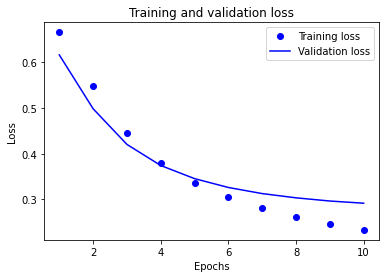

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()